# Preambule

In [1]:
import javabridge
import bioformats as bf
javabridge.start_vm(class_path=bf.JARS)

In [2]:
from collections import OrderedDict

In [3]:
import pandas as pd

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
# bf.ImageReader?

In [6]:
# from lesion.lifio import parse_xml_metadata
import numpy as np

In [7]:
from sys import path as syspath
from os.path import expanduser
syspath.append(expanduser("~/Seafile/functions/"))

In [8]:
from general_functions import autocorr, tally

## Parse metadata

In [9]:
filename = './data/Experiment1.lif'

In [10]:
md = bf.get_omexml_metadata(filename)

xml = bf.OMEXML(md)
Nimages = xml.get_image_count()
mdf = []
for i in range(Nimages):
    im = xml.image(index=i)
    tmp = OrderedDict([(attrib,getattr(im,attrib)) for attrib in ["Name","AcquisitionDate"]])
    for dim in "XYTCZ":
        tmp[dim] = getattr(im.Pixels, "Size"+dim)
    mdf += [tmp]

mdf = pd.DataFrame(mdf)

In [11]:
mdf["AcquisitionDate"] = pd.to_datetime(mdf["AcquisitionDate"])

In [12]:
mdf["Total Pixels"] = mdf["X"]*mdf["Y"]*mdf["T"]

In [13]:
mdf#.sort_values("Total Pixels")

,Name,AcquisitionDate,X,Y,T,C,Z,Total Pixels
0,Image019,2019-07-01 14:02:42,1024,1024,1,1,1,1048576
1,Image022,2019-07-01 14:04:07,1024,1024,1,1,1,1048576
2,Series023,2019-07-01 14:04:44,512,512,1,1,1,262144
3,Series024,2019-07-01 14:05:01,512,512,252,1,1,66060288
4,Series028,2019-07-01 14:10:44,64,64,13490,1,1,55255040
5,Series029,2019-07-01 14:14:10,512,512,415,1,1,108789760
6,Series030,2019-07-01 14:21:30,64,64,6478,1,1,26533888
7,Series032,2019-07-01 14:23:45,64,64,16644,1,1,68173824
8,Series033,2019-07-01 14:28:39,512,512,45,1,1,11796480
9,Series034,2019-07-01 14:29:20,512,512,756,1,1,198180864


In [14]:
# from scipy.stats import entropy

In [15]:
rdr = bf.ImageReader(filename, perform_init=True)

# Bar Plots

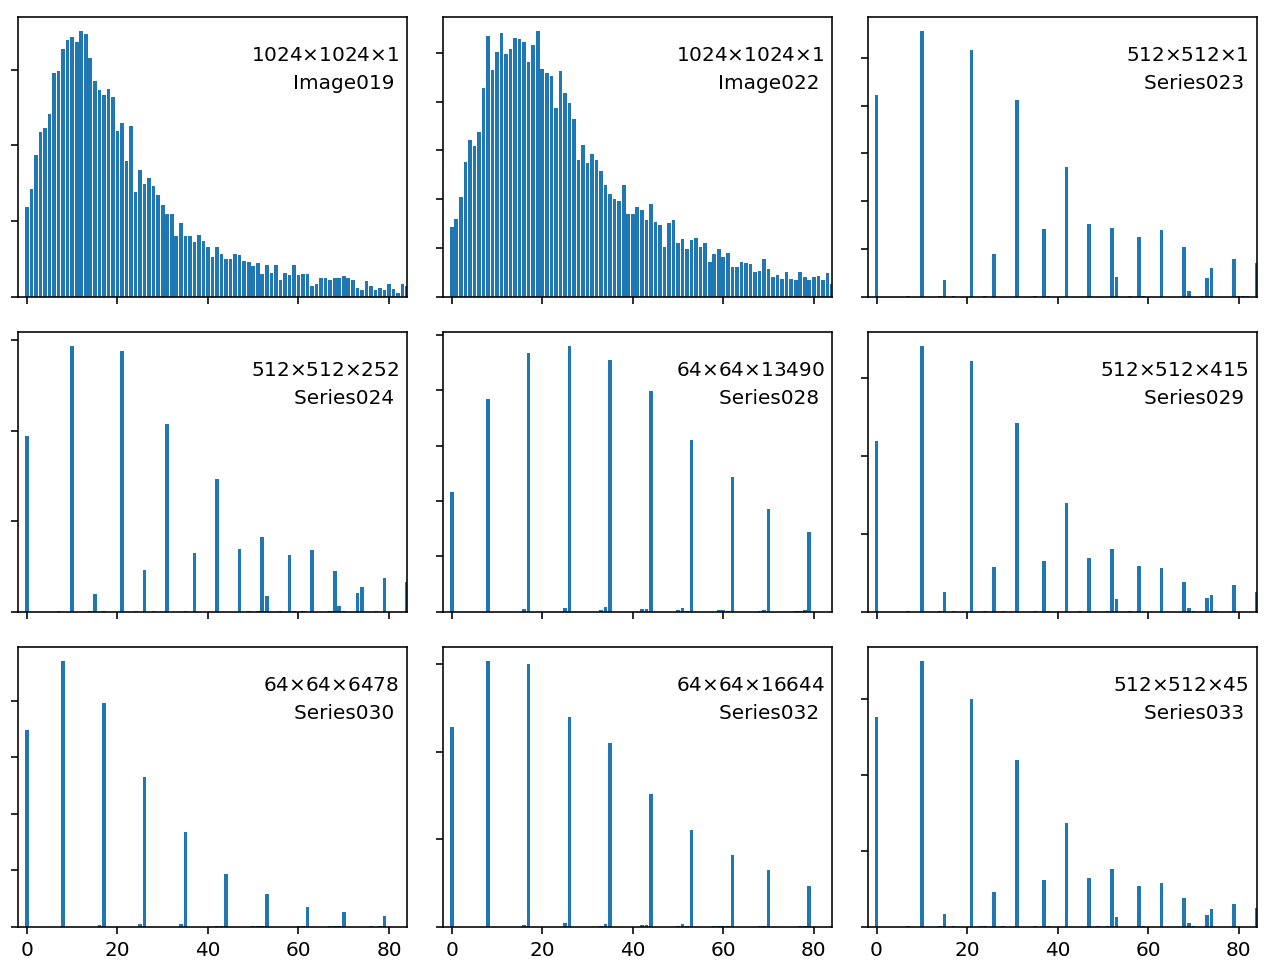

In [28]:
nr,nc = 3,3
fig,axs = plt.subplots(nr,nc,figsize=(nc*3,nr*2.3), sharex=True, sharey=False)
for idx in range(nr*nc):
    try:
        ax = axs.flat[idx]
    except:
        break

    dimensions = mdf.loc[idx,list("XYZCT")]

    image = np.array([
        rdr.read(series=idx, rescale=False,t=t) for t in range(dimensions["T"])
    ])
    tmp = np.random.choice(image.flatten(),10000)
    x,y = np.array(tally(tmp)).T
    ax.bar(x,y/y.sum())
    ax.text(1,.9,r"$%i{\times}%i{\times}%i$  "%tuple(dimensions[list("XYT")]), 
            ha="right",va="top",transform=ax.transAxes)
    ax.text(1,.8,mdf.loc[idx,"Name"]+"  ", 
            ha="right",va="top",transform=ax.transAxes)
#     ax.text(1,.7,("S=%.1f"%entropy(image.flatten()))+"  ", 
#             ha="right",va="top",transform=ax.transAxes)
    ax.set_yticklabels([])
#     break
    ax.set_xlim(-2,np.percentile(tmp,90))
fig.tight_layout()

# Check individual data

In [65]:
idx = 4
dimensions = mdf.loc[idx,list("XYZCT")]

image = np.array([
    rdr.read(series=idx, rescale=False,t=t) for t in range(dimensions["T"])
])
# image = np.vstack([
#     rdr.read(series=idx, rescale=False,t=t) for t in range(dimensions["T"])
# ]).T

In [66]:
image.shape

(13490, 64, 64)

In [67]:
im = np.mean(image, axis=0)
imax = np.array(np.where(im==im.max())).T

In [68]:
imax

array([[32, 60],
       [49, 56]])

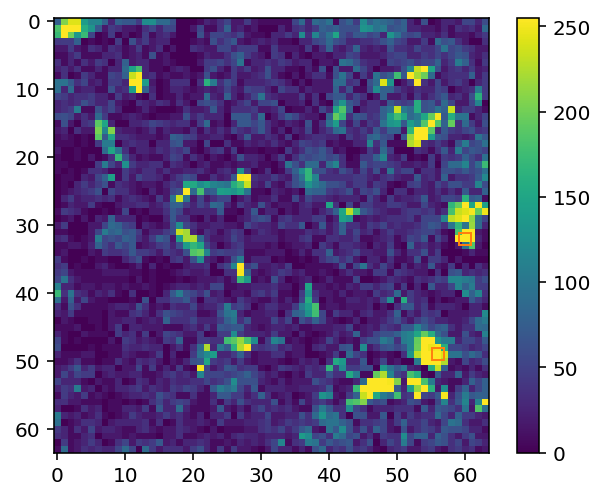

In [70]:
fig = plt.figure(figsize=(5,4))
plt.imshow(image[0])
plt.colorbar()
for x,y in imax:
    plt.plot(y,x,"s", mfc="none",color="C1")


In [71]:
x,y = imax[0]

interesting = np.mean(image[:-1,x-5:x+5,y-5:y+5], axis=(1,2))

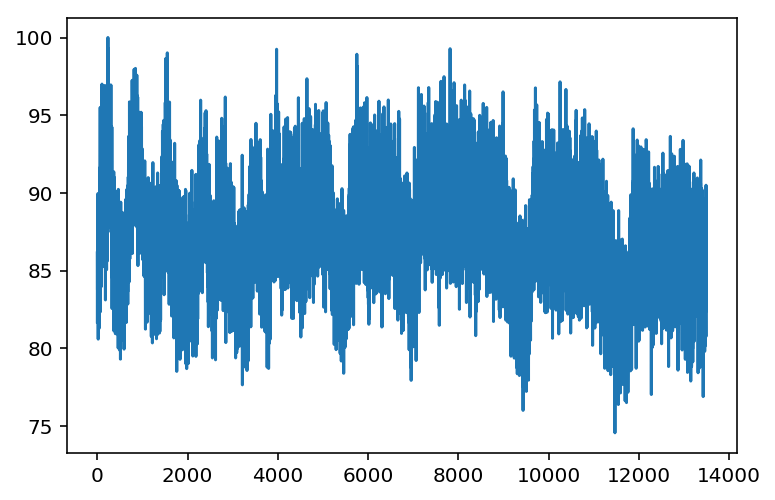

In [72]:
plt.plot(interesting)

In [73]:
from general_functions import moving_average

In [76]:
avg = moving_average(interesting,20)

In [79]:
rest = interesting[9:-10]-avg

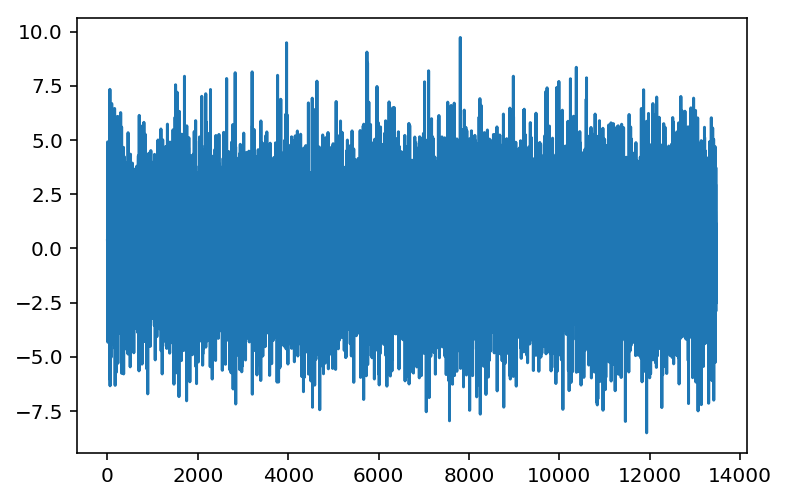

In [80]:
plt.plot(rest)

In [90]:
from scipy.stats import distributions as dst

In [92]:
dst.norm.pdf?

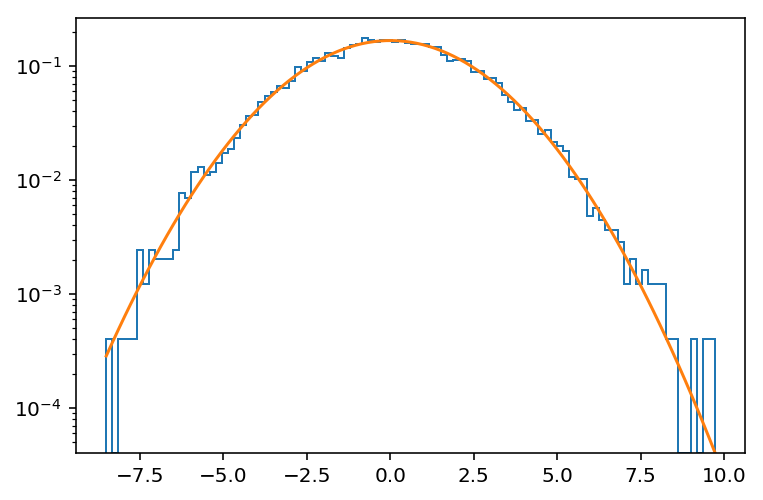

In [97]:
y,x,_ = plt.hist(rest,100,log=True, histtype="step", normed=True)
plt.plot(x,dst.norm.pdf(x,scale=rest.std()))
plt.errorbar(x,y,y*len(rest)**.5, ls="none",marker=".")

In [34]:
tally(image.flatten())

[(0, 26617),
 (7, 71),
 (10, 37189),
 (14, 45),
 (15, 2468),
 (17, 49),
 (21, 34667),
 (23, 6),
 (24, 35),
 (26, 5929),
 (28, 36),
 (30, 4),
 (31, 26646),
 (33, 15),
 (35, 22),
 (37, 8400),
 (38, 24),
 (39, 1),
 (40, 5),
 (42, 18304),
 (44, 4),
 (45, 21),
 (46, 1),
 (47, 9311),
 (49, 15),
 (51, 10),
 (52, 10074),
 (53, 2362),
 (54, 10),
 (56, 21),
 (58, 8638),
 (59, 15),
 (60, 3),
 (61, 6),
 (63, 8696),
 (65, 7),
 (66, 8),
 (67, 2),
 (68, 6299),
 (69, 752),
 (70, 6),
 (72, 10),
 (73, 2653),
 (74, 3774),
 (75, 7),
 (76, 1),
 (77, 6),
 (79, 5420),
 (80, 4),
 (81, 2),
 (82, 5),
 (84, 4485),
 (85, 312),
 (86, 3),
 (87, 1),
 (88, 3),
 (89, 2402),
 (90, 1875),
 (91, 4),
 (93, 3),
 (94, 459),
 (95, 3202),
 (96, 4),
 (97, 3),
 (98, 6),
 (100, 3034),
 (101, 185),
 (103, 5),
 (104, 4),
 (105, 1850),
 (106, 1049),
 (107, 7),
 (109, 4),
 (110, 553),
 (111, 2012),
 (112, 3),
 (113, 1),
 (114, 1),
 (115, 40),
 (116, 2097),
 (117, 105),
 (118, 1),
 (119, 2),
 (120, 1),
 (121, 1280),
 (122, 623),
 (12

(0, 75)

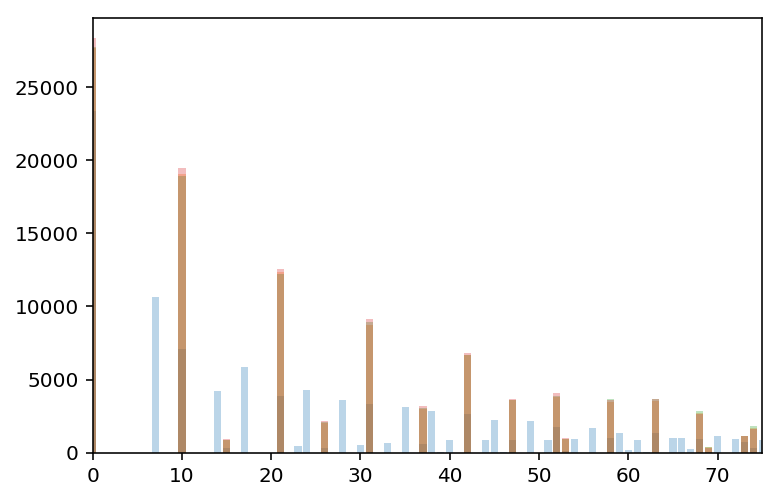

In [72]:
for im in image[:,:4]:
    x,y = np.array(tally(im.flatten())).T
    plt.bar(x,y, alpha = .3)
plt.xlim(0,75)

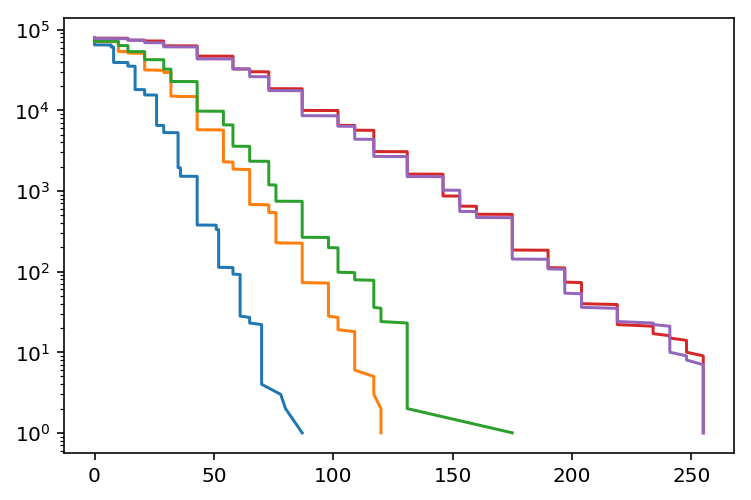

In [55]:

for iPx in [0,10,30,100,150]:
    plt.plot(sorted(image[iPx]), np.arange(1,1+image.shape[1])[::-1])
plt.yscale("log")

In [ ]:
xr = np.arange(1,10)

In [31]:
ACorr = np.array([autocorr(image[iPx],xr,nsplits=20) for iPx in range(len(image))])

In [32]:
ACorr.shape

(512, 2, 9)

In [33]:
ACorr = np.transpose(ACorr,axes=(2,0,1))

In [34]:
ACorr.shape

(9, 512, 2)

<ErrorbarContainer object of 3 artists>

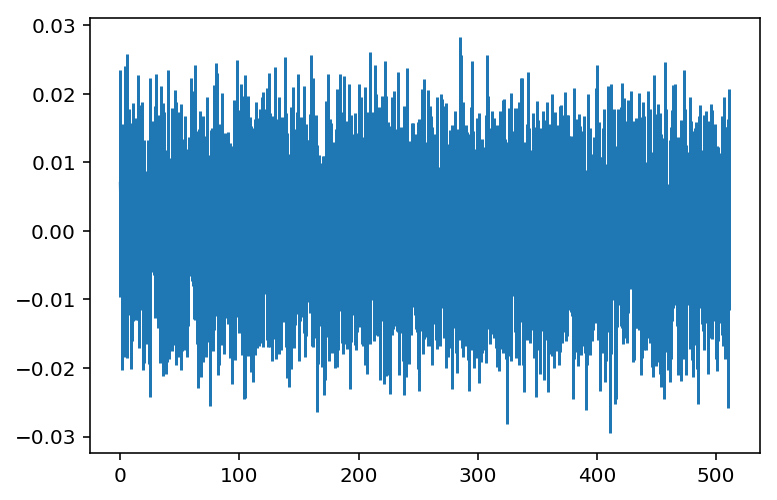

In [36]:
plt.errorbar(range(len(image)),*ACorr[0].T)

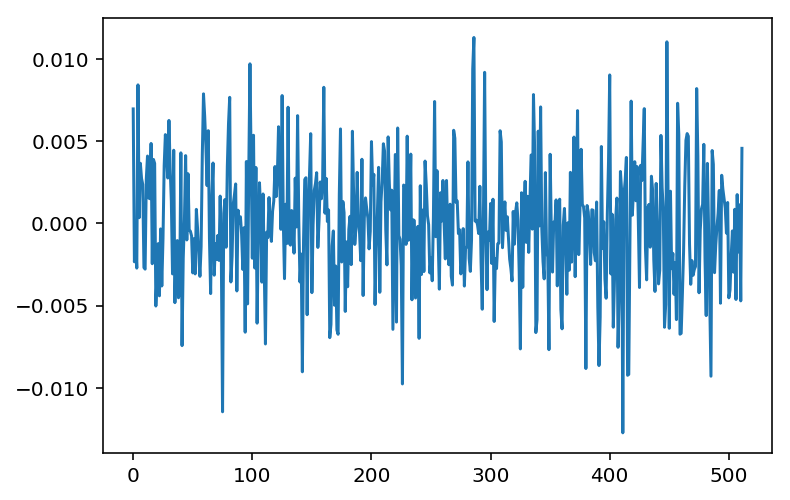

In [39]:
plt.plot(ACorr[0].T[0])

In [41]:
zscores = np.abs(ACorr[0].T[0])/ACorr[0].T[1]

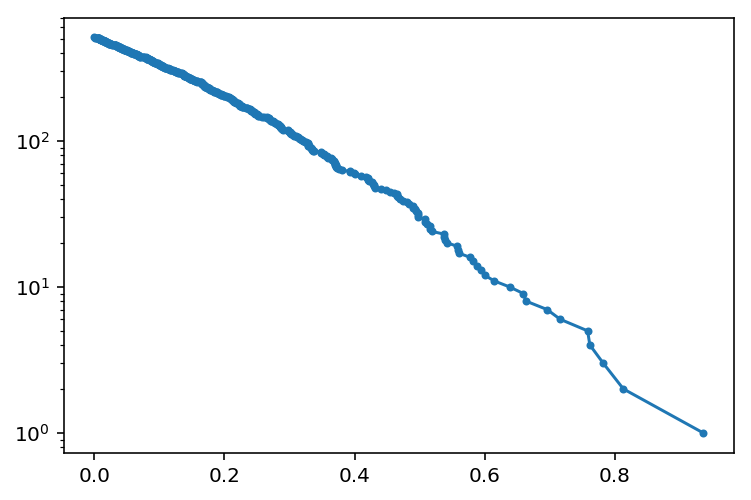

In [44]:
plt.plot(sorted(zscores), np.arange(1,1+len(image))[::-1],".-")
plt.yscale("log")

In [45]:
orderedPxs = np.argsort(zscores)[::-1]

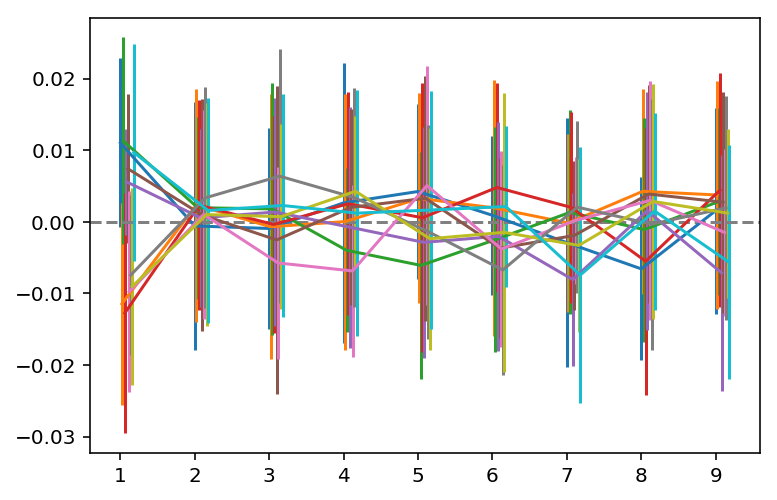

In [49]:
xr = np.arange(1,10)
ii=0
for iPx in orderedPxs[:10]:
    y, yerr = autocorr(image[iPx],xr,nsplits=20)
    plt.errorbar(xr+ii*.02,y,yerr)
    ii += 1
plt.axhline(0,ls="--", color="grey")

In [ ]:
 image

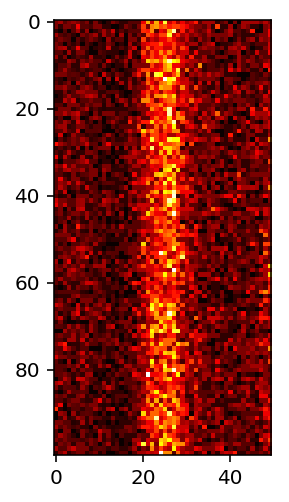

In [47]:
plt.imshow(image[0][:100,50:100],cmap=plt.cm.hot)

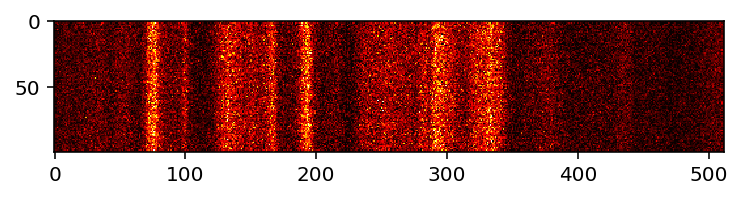

In [49]:
plt.imshow(image[0][-100:,:],cmap=plt.cm.hot)

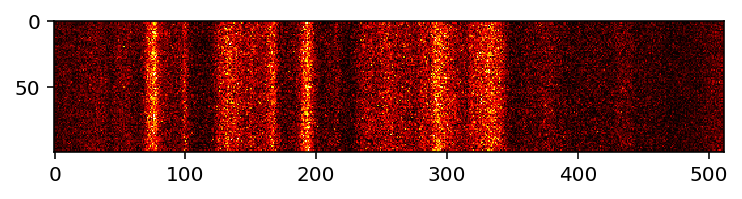

In [51]:
plt.imshow(image[1][:100,:],cmap=plt.cm.hot)

In [20]:
javabridge.kill_vm()